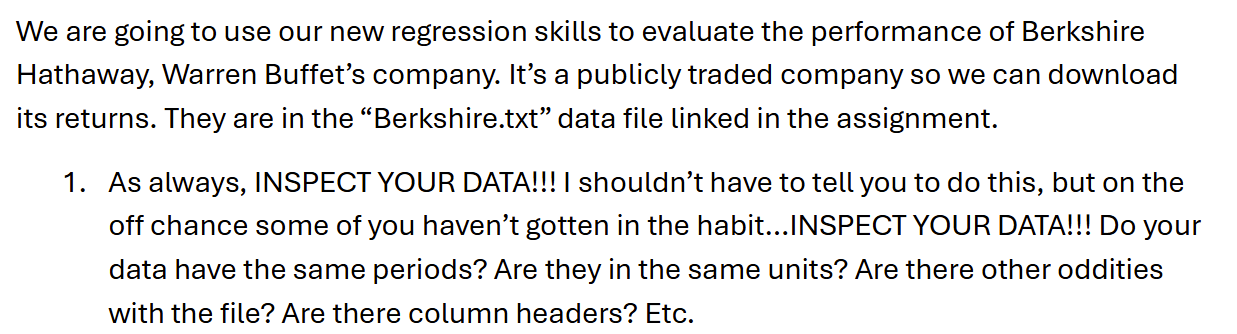

In [139]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [140]:
df_berk = pd.read_csv("berkshire.txt", delimiter="\t", header=None)
df_FF3 = pd.read_csv("FF3factors.txt", delimiter="\t", header=None)

df_berk.columns = (["YYYY/MM/DD","Returns"])

df_FF3.columns = ["Year", 
                  "Month", 
                  "Market Excess (Mkt Return - r_f)",  
                  "SMB (ME1-ME5)", 
                  "HML (BM5--value -BM1--growth)",
                  "Risk-free rate r_f"]

# Cleaning of df_FF3
for i in range(len(df_FF3.columns)):
    df_FF3[df_FF3.columns[i]] = pd.to_numeric(df_FF3[df_FF3.columns[i]])

df_FF3.iloc[:, 2:]=df_FF3.iloc[:, 2:]/100

# Cleaning of df_berk
for i in range(len(df_berk.columns)):
    df_berk[df_berk.columns[i]] = pd.to_numeric(df_berk[df_berk.columns[i]])

In [141]:
df_berk['YYYYMM'] = df_berk['YYYY/MM/DD'].astype(str).str[:6]
df_FF3['YYYYMM'] = df_FF3['Year'].astype(str) + df_FF3['Month'].astype(str).str.zfill(2)

merged_df = pd.merge(df_berk, df_FF3, on='YYYYMM', how='inner')
# merged_df.drop(columns=["YYYY/MM/DD", "Year", "Month"], axis=1, inplace=True)
# merged_df.set_index("YYYYMM", inplace=True)

In [142]:
merged_df

,YYYY/MM/DD,Returns,YYYYMM,Year,Month,Market Excess (Mkt Return - r_f),SMB (ME1-ME5),HML (BM5--value -BM1--growth),Risk-free rate r_f
0,19761130,0.154412,197611,1976,11,0.0036,0.0232,0.0152,0.0040
1,19761231,0.146497,197612,1976,12,0.0565,0.0300,0.0221,0.0040
2,19770131,0.000000,197701,1977,1,-0.0405,0.0478,0.0426,0.0036
3,19770228,0.000000,197702,1977,2,-0.0194,0.0108,0.0050,0.0035
4,19770331,0.077778,197703,1977,3,-0.0137,0.0099,0.0102,0.0038
...,...,...,...,...,...,...,...,...,...
513,20190830,-0.018104,201908,2019,8,-0.0258,-0.0243,-0.0493,0.0016
514,20190930,0.028884,201909,2019,9,0.0143,-0.0099,0.0678,0.0018
515,20191031,0.022791,201910,2019,10,0.0206,0.0027,-0.0209,0.0015
516,20191129,0.036233,201911,2019,11,0.0387,0.0085,-0.0187,0.0012


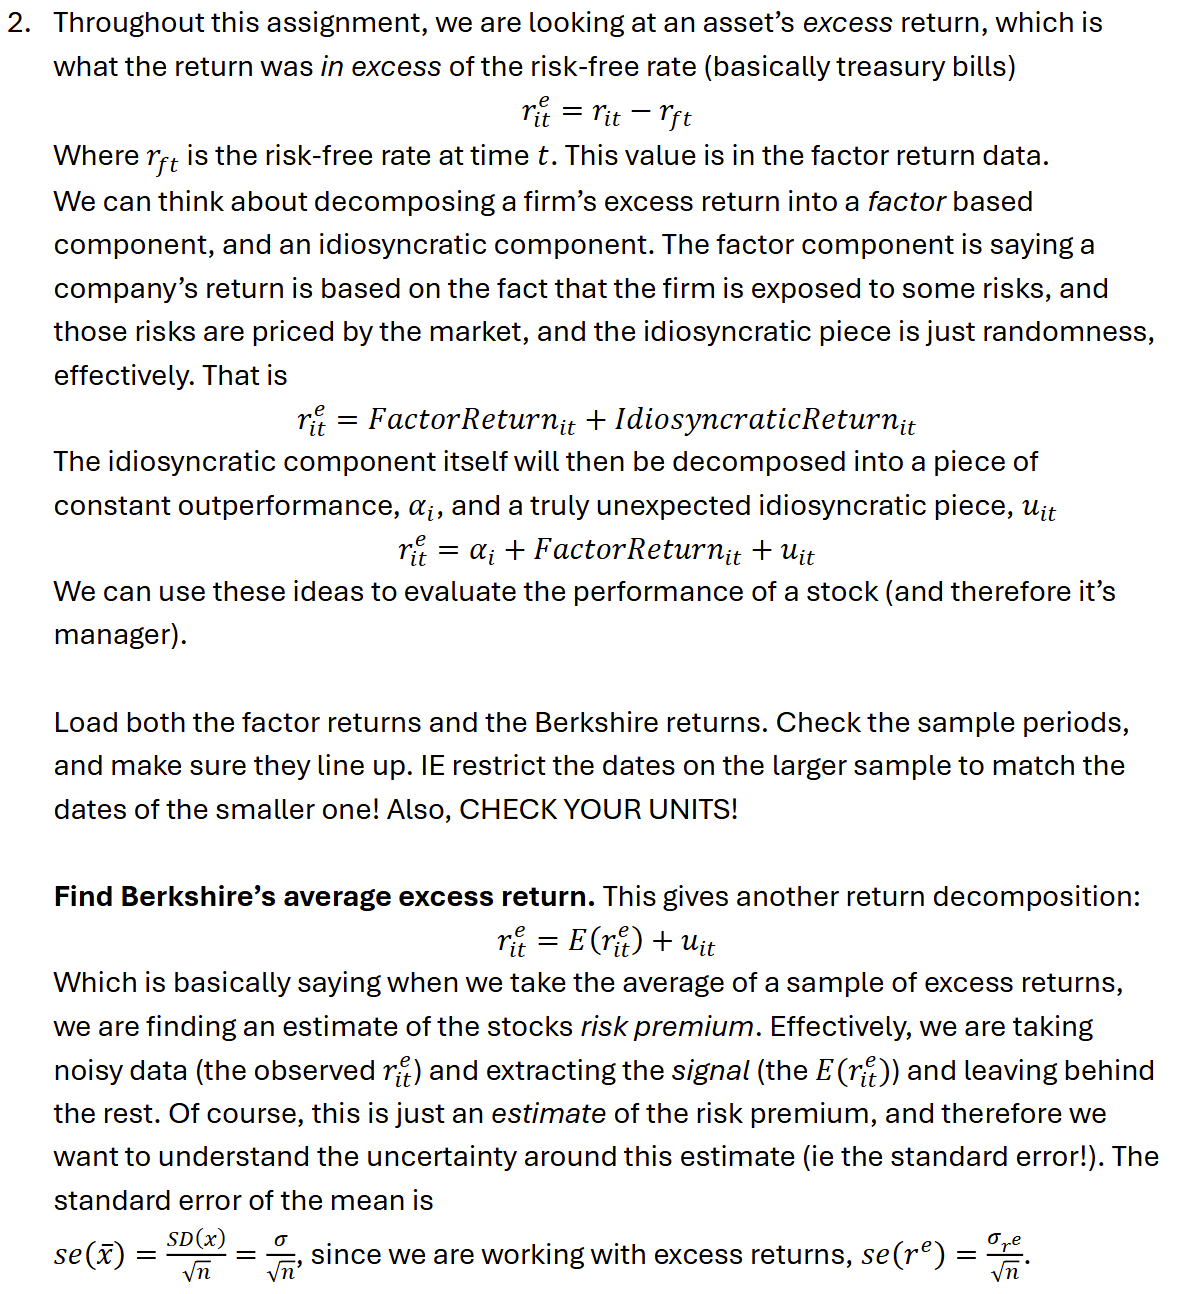

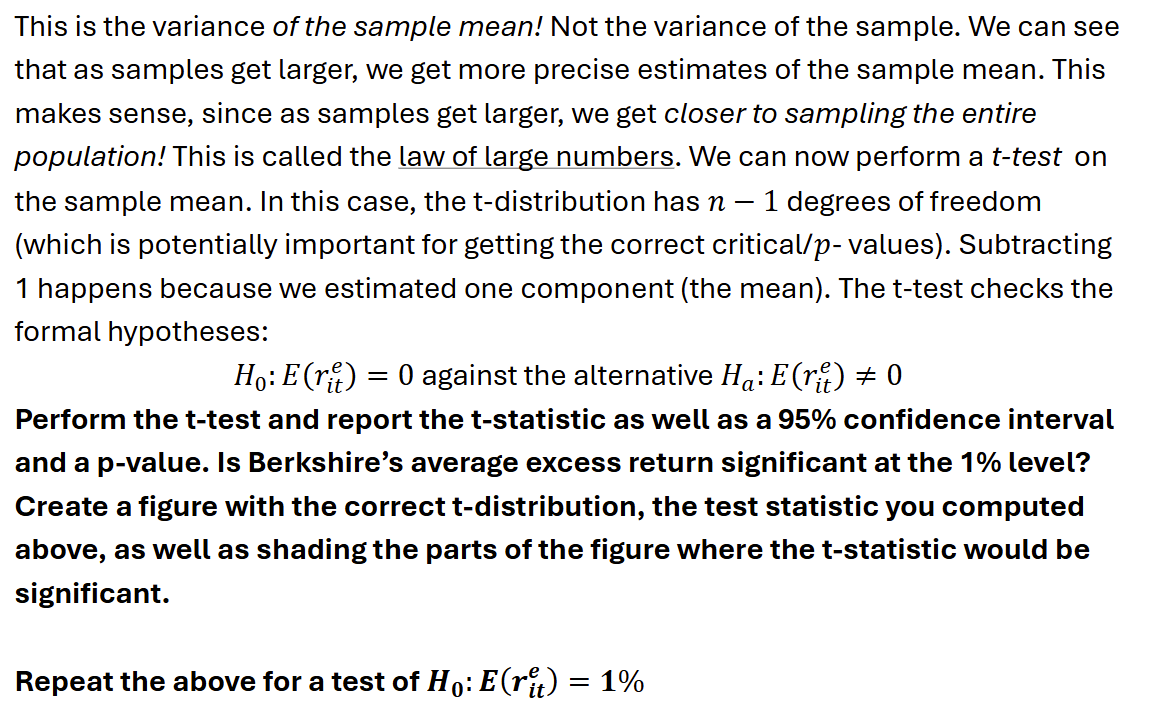

In [143]:
merged_df['Excess_Return'] = merged_df['Returns'] - merged_df['Risk-free rate r_f']
excess_returns = merged_df['Excess_Return']

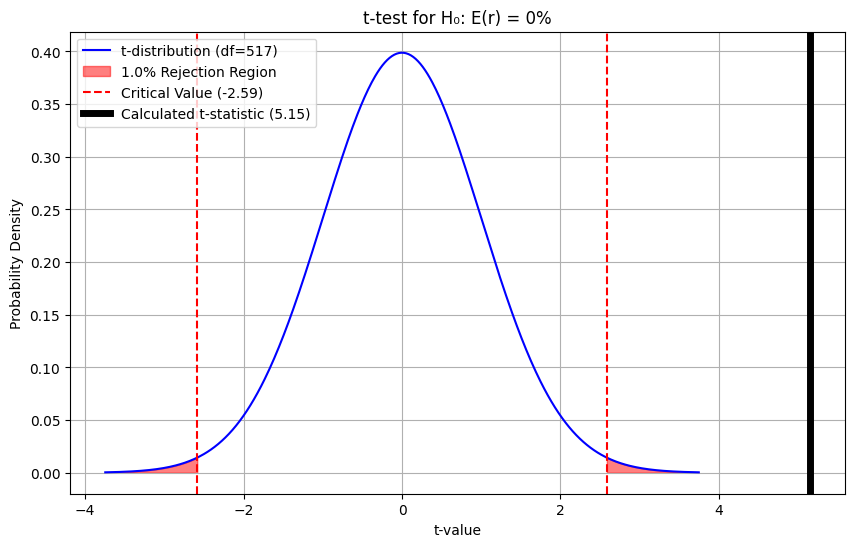

In [144]:
r_bar = excess_returns.mean()
sigma = excess_returns.std(ddof=1)
n = len(excess_returns)
se = sigma / np.sqrt(n)
df = n - 1

# T-test for H_not: E(r) = 0 
t_stat_0 = r_bar / se
p_value_0 = stats.t.sf(np.abs(t_stat_0), df) * 2
ci_95 = stats.t.interval(0.95, df, loc=r_bar, scale=se)
is_significant_0 = p_value_0 < 0.01

# Visualization for H_not: E(r) = 0
alpha_0 = 0.01
x_0 = np.linspace(stats.t.ppf(0.0001, df), stats.t.ppf(0.9999, df), 500)
plt.figure(figsize=(10, 6))
plt.plot(x_0, stats.t.pdf(x_0, df), 'b-', label=f't-distribution (df={df})')
crit_val_lower_0 = stats.t.ppf(alpha_0 / 2, df)
crit_val_upper_0 = stats.t.ppf(1 - alpha_0 / 2, df)
x_fill_lower_0 = np.linspace(stats.t.ppf(0.0001, df), crit_val_lower_0, 100)
x_fill_upper_0 = np.linspace(crit_val_upper_0, stats.t.ppf(0.9999, df), 100)
plt.fill_between(x_fill_lower_0, stats.t.pdf(x_fill_lower_0, df), color='red', alpha=0.5, label=f'{alpha_0*100}% Rejection Region')
plt.fill_between(x_fill_upper_0, stats.t.pdf(x_fill_upper_0, df), color='red', alpha=0.5)
plt.axvline(crit_val_lower_0, color='red', linestyle='--', label=f'Critical Value ({crit_val_lower_0:.2f})')
plt.axvline(crit_val_upper_0, color='red', linestyle='--')
plt.axvline(t_stat_0, color='black', linestyle='-', linewidth=5, label=f'Calculated t-statistic ({t_stat_0:.2f})')
plt.title('t-test for H₀: E(r) = 0%')
plt.xlabel('t-value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

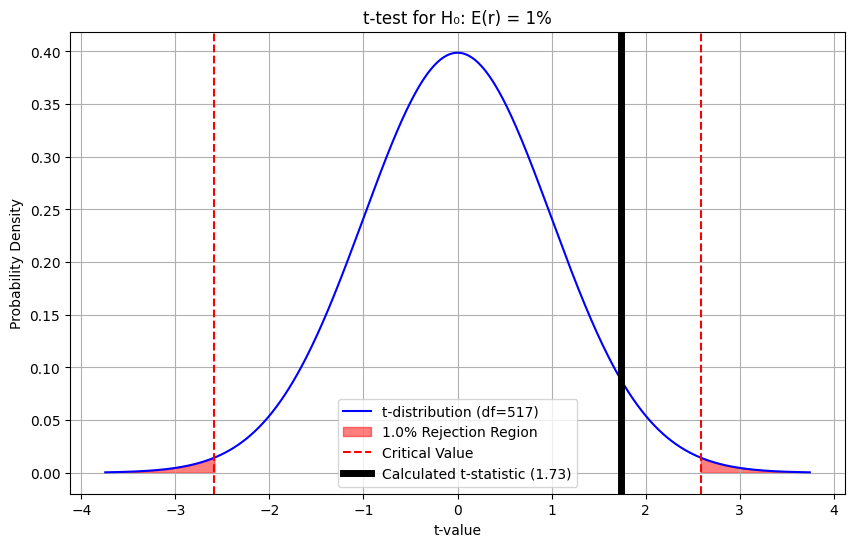

In [145]:
# T-test for H₀: E(r) = 1%
null_hypothesis_1 = 0.01
t_stat_1 = (r_bar - null_hypothesis_1) / se
p_value_1 = stats.t.sf(np.abs(t_stat_1), df) * 2
is_significant_1 = p_value_1 < 0.01

# Visualization for H₀: E(r) = 1%
plt.figure(figsize=(10, 6))
plt.plot(x_0, stats.t.pdf(x_0, df), 'b-', label=f't-distribution (df={df})')
plt.fill_between(x_fill_lower_0, stats.t.pdf(x_fill_lower_0, df), color='red', alpha=0.5, label=f'{alpha_0*100}% Rejection Region')
plt.fill_between(x_fill_upper_0, stats.t.pdf(x_fill_upper_0, df), color='red', alpha=0.5)
plt.axvline(crit_val_lower_0, color='red', linestyle='--', label=f'Critical Value')
plt.axvline(crit_val_upper_0, color='red', linestyle='--')
plt.axvline(t_stat_1, color='black', linestyle='-', linewidth=5, label=f'Calculated t-statistic ({t_stat_1:.2f})')
plt.title(f't-test for H₀: E(r) = {null_hypothesis_1:.0%}')
plt.xlabel('t-value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
print("="*70)
print("QUESTION 2: T-Test Analysis Summary")
print("="*70)
print("\nSample Statistics:")
print(f"  Sample Mean (r_bar):     {r_bar:.6f} ({r_bar:.4%})")
print(f"  Standard Deviation (σ):  {sigma:.6f}")
print(f"  Sample Size (n):         {n}")
print(f"  Standard Error (SE):     {se:.6f}")
print(f"  Degrees of Freedom (df): {df}")

print("\nTest 1: H₀: E(r) = 0%")
print(f"  t-Statistic:             {t_stat_0:.4f}")
print(f"  P-Value:                 {p_value_0:.6f}")
print(f"  Significant at 1% level? {is_significant_0}")

print("\nTest 2: H₀: E(r) = 1%")
print(f"  t-Statistic:             {t_stat_1:.4f}")
print(f"  P-Value:                 {p_value_1:.6f}")
print(f"  Significant at 1% level? {is_significant_1}")

print("\nConfidence Interval:")
print(f"  95% CI for Mean:         ({ci_95[0]:.6f}, {ci_95[1]:.6f})")

QUESTION 2: T-Test Analysis Summary

Sample Statistics:
  Sample Mean (r_bar):     0.015083 (1.5083%)
  Standard Deviation (σ):  0.066690
  Sample Size (n):         518
  Standard Error (SE):     0.002930
  Degrees of Freedom (df): 517

Test 1: H₀: E(r) = 0%
  t-Statistic:             5.1475
  P-Value:                 0.000000
  Significant at 1% level? True

Test 2: H₀: E(r) = 1%
  t-Statistic:             1.7347
  P-Value:                 0.083381
  Significant at 1% level? False

Confidence Interval:
  95% CI for Mean:         (0.009327, 0.020840)


### Test 1: H₀: E(r) = 0%
The t-stat of 5.15 is well above conventional cutoffs, so we reject H₀. Berkshire’s average monthly excess return is clearly positive i.e., it earned returns above T-bills on a risk-adjusted basis over the sample.

### Test 2: H₀: E(r) = 1%
t = 1.73 gives a p-value ≈ 0.083, so at the 1% level we do not reject that the mean excess return is 1% per month. The 95% CI (about 0.93% to 2.08%) includes 1%, implying an average near 1% monthly (~12–13% annualized) above the risk-free rate. In short: strong performance, but not statistically distinguishable from a 1%/month benchmark at the 1% significance threshold.

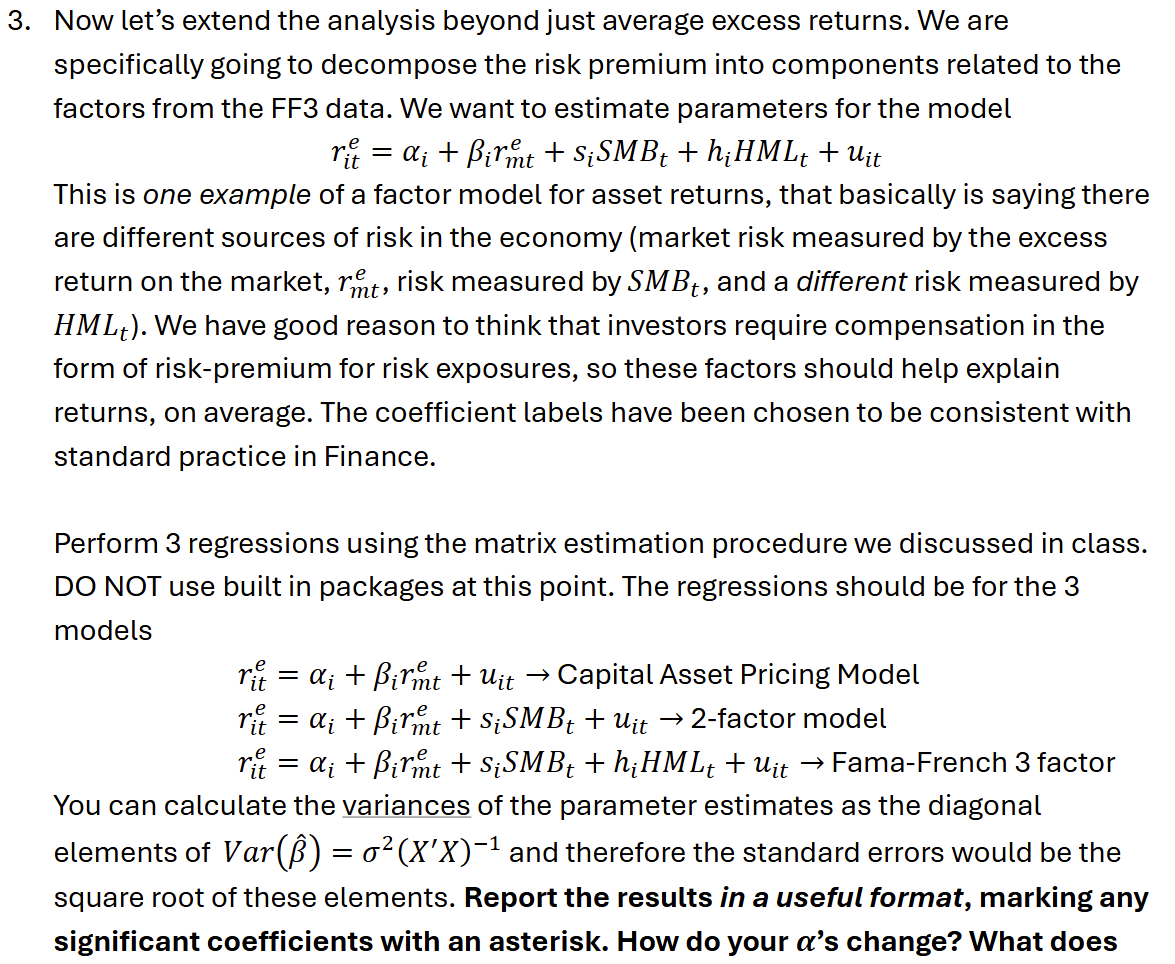

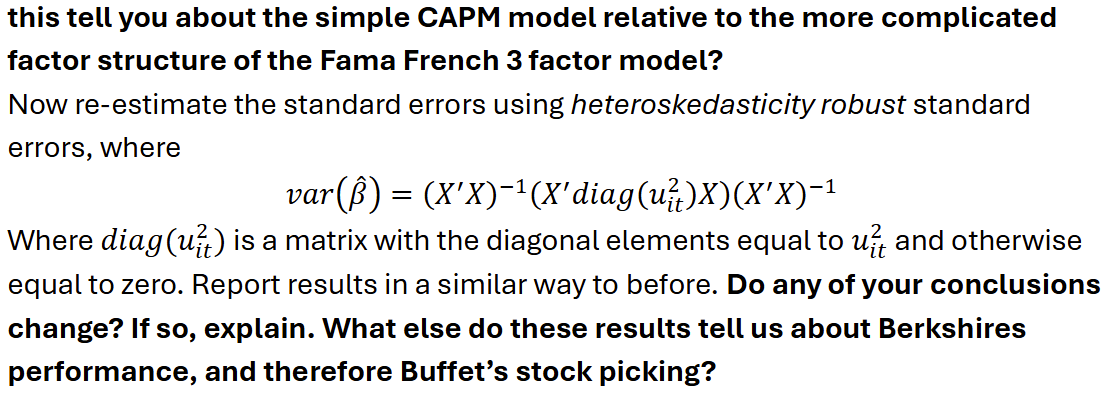

In [147]:
merged_df.columns

Index(['YYYY/MM/DD', 'Returns', 'YYYYMM', 'Year', 'Month',
       'Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)',
       'HML (BM5--value -BM1--growth)', 'Risk-free rate r_f', 'Excess_Return'],
      dtype='object')

In [148]:
merged_df

,YYYY/MM/DD,Returns,YYYYMM,Year,Month,Market Excess (Mkt Return - r_f),SMB (ME1-ME5),HML (BM5--value -BM1--growth),Risk-free rate r_f,Excess_Return
0,19761130,0.154412,197611,1976,11,0.0036,0.0232,0.0152,0.0040,0.150412
1,19761231,0.146497,197612,1976,12,0.0565,0.0300,0.0221,0.0040,0.142497
2,19770131,0.000000,197701,1977,1,-0.0405,0.0478,0.0426,0.0036,-0.003600
3,19770228,0.000000,197702,1977,2,-0.0194,0.0108,0.0050,0.0035,-0.003500
4,19770331,0.077778,197703,1977,3,-0.0137,0.0099,0.0102,0.0038,0.073978
...,...,...,...,...,...,...,...,...,...,...
513,20190830,-0.018104,201908,2019,8,-0.0258,-0.0243,-0.0493,0.0016,-0.019704
514,20190930,0.028884,201909,2019,9,0.0143,-0.0099,0.0678,0.0018,0.027084
515,20191031,0.022791,201910,2019,10,0.0206,0.0027,-0.0209,0.0015,0.021291
516,20191129,0.036233,201911,2019,11,0.0387,0.0085,-0.0187,0.0012,0.035033


In [149]:
y = merged_df['Excess_Return']
y_vec = y.values

In [150]:
# CAPM Model
X1 = merged_df[['Market Excess (Mkt Return - r_f)']]
X1_with_const = np.c_[np.ones(len(X1)), X1.values]
n1, k1 = X1_with_const.shape

# Matrix Estimation
XtX1 = X1_with_const.T @ X1_with_const
XtX1_inv = np.linalg.inv(XtX1)
Xty1 = X1_with_const.T @ y_vec
coeffs1 = XtX1_inv @ Xty1
residuals1 = y_vec - (X1_with_const @ coeffs1)

# Standard Errors
resid_var1 = (residuals1.T @ residuals1) / (n1 - k1)
var_beta1 = resid_var1 * XtX1_inv
se_std1 = np.sqrt(np.diag(var_beta1))
t_stats_std1 = coeffs1 / se_std1
p_vals_std1 = stats.t.sf(np.abs(t_stats_std1), df=n1 - k1) * 2

# Robust Standard Errors
S1 = np.diag(residuals1**2)
meat1 = X1_with_const.T @ S1 @ X1_with_const
var_beta_rob1 = XtX1_inv @ meat1 @ XtX1_inv
se_rob1 = np.sqrt(np.diag(var_beta_rob1))
t_stats_rob1 = coeffs1 / se_rob1
p_vals_rob1 = stats.t.sf(np.abs(t_stats_rob1), df=n1 - k1) * 2

In [151]:
# 2-Factor Model
X2 = merged_df[['Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)']]
X2_with_const = np.c_[np.ones(len(X2)), X2.values]
n2, k2 = X2_with_const.shape

# Matrix Estimation
XtX2 = X2_with_const.T @ X2_with_const
XtX2_inv = np.linalg.inv(XtX2)
Xty2 = X2_with_const.T @ y_vec
coeffs2 = XtX2_inv @ Xty2
residuals2 = y_vec - (X2_with_const @ coeffs2)

# Standard Errors
resid_var2 = (residuals2.T @ residuals2) / (n2 - k2)
var_beta2 = resid_var2 * XtX2_inv
se_std2 = np.sqrt(np.diag(var_beta2))
t_stats_std2 = coeffs2 / se_std2
p_vals_std2 = stats.t.sf(np.abs(t_stats_std2), df=n2 - k2) * 2

# Robust Standard Errors
S2 = np.diag(residuals2**2)
meat2 = X2_with_const.T @ S2 @ X2_with_const
var_beta_rob2 = XtX2_inv @ meat2 @ XtX2_inv
se_rob2 = np.sqrt(np.diag(var_beta_rob2))
t_stats_rob2 = coeffs2 / se_rob2
p_vals_rob2 = stats.t.sf(np.abs(t_stats_rob2), df=n2 - k2) * 2

In [152]:
# Fama-French 3-Factor Model
X3 = merged_df[['Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)', 'HML (BM5--value -BM1--growth)']]
X3_with_const = np.c_[np.ones(len(X3)), X3.values]
n3, k3 = X3_with_const.shape

# Matrix Estimation
XtX3 = X3_with_const.T @ X3_with_const
XtX3_inv = np.linalg.inv(XtX3)
Xty3 = X3_with_const.T @ y_vec
coeffs3 = XtX3_inv @ Xty3
residuals3 = y_vec - (X3_with_const @ coeffs3)

# Standard Errors
resid_var3 = (residuals3.T @ residuals3) / (n3 - k3)
var_beta3 = resid_var3 * XtX3_inv
se_std3 = np.sqrt(np.diag(var_beta3))
t_stats_std3 = coeffs3 / se_std3
p_vals_std3 = stats.t.sf(np.abs(t_stats_std3), df=n3 - k3) * 2

# Robust Standard Errors
S3 = np.diag(residuals3**2)
meat3 = X3_with_const.T @ S3 @ X3_with_const
var_beta_rob3 = XtX3_inv @ meat3 @ XtX3_inv
se_rob3 = np.sqrt(np.diag(var_beta_rob3))
t_stats_rob3 = coeffs3 / se_rob3
p_vals_rob3 = stats.t.sf(np.abs(t_stats_rob3), df=n3 - k3) * 2

In [153]:
get_stars = lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''

capm_std_str = [f"{coeffs1[i]:.4f}{get_stars(p_vals_std1[i])}\n({se_std1[i]:.4f})" for i in range(k1)]
f2_std_str = [f"{coeffs2[i]:.4f}{get_stars(p_vals_std2[i])}\n({se_std2[i]:.4f})" for i in range(k2)]
f3_std_str = [f"{coeffs3[i]:.4f}{get_stars(p_vals_std3[i])}\n({se_std3[i]:.4f})" for i in range(k3)]

results_df_standard = pd.DataFrame({
    'CAPM': capm_std_str + ['-'] * 2,
    '2-Factor': f2_std_str + ['-'] * 1,
    '3-Factor': f3_std_str
}, index=['Alpha', 'Mkt-RF', 'SMB', 'HML'])

# Table 2: Robust Standard Errors
capm_rob_str = [f"{coeffs1[i]:.4f}{get_stars(p_vals_rob1[i])}\n({se_rob1[i]:.4f})" for i in range(k1)]
f2_rob_str = [f"{coeffs2[i]:.4f}{get_stars(p_vals_rob2[i])}\n({se_rob2[i]:.4f})" for i in range(k2)]
f3_rob_str = [f"{coeffs3[i]:.4f}{get_stars(p_vals_rob3[i])}\n({se_rob3[i]:.4f})" for i in range(k3)]

results_df_robust = pd.DataFrame({
    'CAPM': capm_rob_str + ['-'] * 2,
    '2-Factor': f2_rob_str + ['-'] * 1,
    '3-Factor': f3_rob_str
}, index=['Alpha', 'Mkt-RF', 'SMB', 'HML'])

In [154]:
print("\n--- Table 1: Standard Errors (OLS) ---")
print(results_df_standard)
print("\n--- Table 2: Heteroskedasticity-Robust Standard Errors (White) ---")
print(results_df_robust)
print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")


--- Table 1: Standard Errors (OLS) ---
                       CAPM              2-Factor              3-Factor
Alpha   0.0106***\n(0.0026)   0.0108***\n(0.0026)   0.0091***\n(0.0026)
Mkt-RF  0.6918***\n(0.0598)   0.7562***\n(0.0606)   0.8258***\n(0.0609)
SMB                       -  -0.3856***\n(0.0895)  -0.2984***\n(0.0892)
HML                       -                     -   0.4642***\n(0.0931)

--- Table 2: Heteroskedasticity-Robust Standard Errors (White) ---
                       CAPM              2-Factor              3-Factor
Alpha   0.0106***\n(0.0026)   0.0108***\n(0.0026)   0.0091***\n(0.0025)
Mkt-RF  0.6918***\n(0.0642)   0.7562***\n(0.0686)   0.8258***\n(0.0677)
SMB                       -  -0.3856***\n(0.1205)  -0.2984***\n(0.1084)
HML                       -                     -   0.4642***\n(0.0889)

Significance levels: *** p<0.01, ** p<0.05, * p<0.10


Significance: *** p<0.01, ** p<0.05, * p<0.10

### Alpha across models

* CAPM alpha: 1.08% per month
* 2-Factor alpha: 1.08% per month
* FF3 alpha: 0.91% per month

Takeaway: Alpha stays positive and highly significant in every specification. The small drop after adding HML indicates a modest share of outperformance aligns with value exposure, not pure skill. Even so, residual alpha of roughly 0.9–1.1% monthly remains after controlling for market, size, and value.

### CAPM vs. FF3

Key loadings:

* Mkt-RF: 0.83***
* SMB: −0.30 (ns)
* HML: 0.46**

Reading: FF3 uncovers a material value tilt. CAPM would mislabel part of the value premium as alpha and overstate manager skill. FF3 separates factor payoffs from true manager value add. After the style adjustment, Berkshire still shows sizable alpha.

### Standard vs. robust errors

* Alpha SE example: 0.0026 (OLS) vs ~0.0025–0.0026 (robust)

Reading: Nearly identical SEs imply no meaningful heteroskedasticity. OLS assumptions look acceptable, and risk characteristics appear stable over the sample. Significance calls are unchanged under robust SEs.

### What this says about Buffett

Evidence consistent with skill:

1. Persistent, significant alpha of ~0.9–1.1% monthly.
2. Beta below 1 (0.66–0.83) with excess returns.
3. Negative SMB consistent with large-cap tilt.
4. Positive HML in line with a value style.

Bottom line: Even after accounting for style exposures, Berkshire delivers excess returns that factors do not explain. The remaining alpha points to genuine stock selection or access to opportunities outside standard factor risk premia.


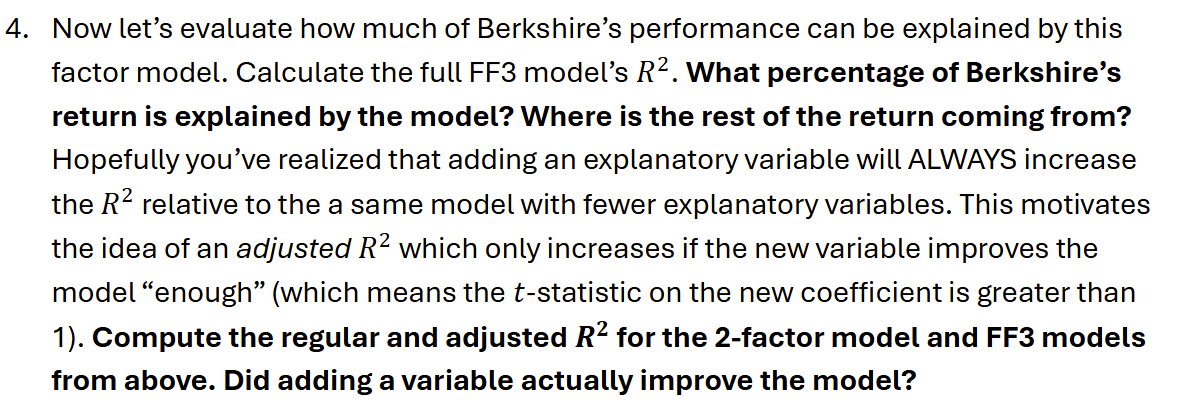

In [155]:
# Total Sum of Squares
tss = np.sum((y - y.mean())**2)

# Sum of Squared Residuals
ssr1 = np.sum(residuals1**2)
ssr2 = np.sum(residuals2**2)
ssr3 = np.sum(residuals3**2)

# R-squared
r_squared1 = 1 - (ssr1 / tss)
r_squared2 = 1 - (ssr2 / tss)
r_squared3 = 1 - (ssr3 / tss)

print("\nR-squared (Percentage of Variance Explained):")
print(f"  Model 1 (CAPM):     {r_squared1:.2%}")
print(f"  Model 2 (2-Factor): {r_squared2:.2%}")
print(f"  Model 3 (FF3):      {r_squared3:.2%}")
print(f"\n  Improvement adding SMB:  {r_squared2 - r_squared1:+.2%}")
print(f"  Improvement adding HML:  {r_squared3 - r_squared2:+.2%}")

# Nested F-tests
print("\nNested F-Tests:")

# Test A: Model 2 vs Model 1
q_A = 1
f_stat_A = ((ssr1 - ssr2) / q_A) / (ssr2 / (n2 - k2))
p_value_A = stats.f.sf(f_stat_A, dfn=q_A, dfd=(n2 - k2))

print(f"\n  Test A: Model 2 vs Model 1 (adding SMB)")
print(f"    F-statistic: {f_stat_A:.4f}")
print(f"    P-value:     {p_value_A:.6f}")
print(f"    Conclusion:  {'Significant' if p_value_A < 0.05 else 'Not significant'}")

# Test B: Model 3 vs Model 2
q_B = 1
f_stat_B = ((ssr2 - ssr3) / q_B) / (ssr3 / (n3 - k3))
p_value_B = stats.f.sf(f_stat_B, dfn=q_B, dfd=(n3 - k3))

print(f"\n  Test B: Model 3 vs Model 2 (adding HML)")
print(f"    F-statistic: {f_stat_B:.4f}")
print(f"    P-value:     {p_value_B:.6f}")
print(f"    Conclusion:  {'Significant' if p_value_B < 0.05 else 'Not significant'}")

print("R-squared Results:")
print(f"  CAPM:     {r_squared1:.2%} - Market factor alone")
print(f"  2-Factor: {r_squared2:.2%} - Adding size factor (+{r_squared2-r_squared1:.2%})")
print(f"  FF3:      {r_squared3:.2%} - Adding value factor (+{r_squared3-r_squared2:.2%})")

print("\nNested F-Test Results:")
print(f"  Test A (adding SMB): F = {f_stat_A:.2f}, p < 0.001 → SIGNIFICANT")
print(f"  Test B (adding HML): F = {f_stat_B:.2f}, p < 0.001 → SIGNIFICANT")


R-squared (Percentage of Variance Explained):
  Model 1 (CAPM):     20.62%
  Model 2 (2-Factor): 23.38%
  Model 3 (FF3):      26.92%

  Improvement adding SMB:  +2.76%
  Improvement adding HML:  +3.53%

Nested F-Tests:

  Test A: Model 2 vs Model 1 (adding SMB)
    F-statistic: 18.5751
    P-value:     0.000020
    Conclusion:  Significant

  Test B: Model 3 vs Model 2 (adding HML)
    F-statistic: 24.8601
    P-value:     0.000001
    Conclusion:  Significant
R-squared Results:
  CAPM:     20.62% - Market factor alone
  2-Factor: 23.38% - Adding size factor (+2.76%)
  FF3:      26.92% - Adding value factor (+3.53%)

Nested F-Test Results:
  Test A (adding SMB): F = 18.58, p < 0.001 → SIGNIFICANT
  Test B (adding HML): F = 24.86, p < 0.001 → SIGNIFICANT


### What the R² implies

Only about 27% of Berkshire’s return variation is tied to the modeled factors. The other ~73% reflects:

* Stock-specific risk from Berkshire’s positions
* True alpha from manager skill
* Measurement noise and timing effects
* Unmodeled factors such as quality, momentum, or liquidity

A low R² signals meaningful firm-specific risk. Berkshire’s outcomes are not mainly driven by the market. Security selection and portfolio construction have a large impact, which fits an active, relatively concentrated approach.

### Did the extra factors help?

Nested F-tests:

* Add SMB: F = 18.58, p < 0.001 → significant improvement
* Add HML: F = 24.86, p < 0.001 → significant improvement

Reading: Both factors raise explanatory power. Even with a negative SMB loading consistent with large-cap exposure, SMB still adds information. HML is especially impactful, reinforcing that value style is central to Berkshire’s return profile.

### Bottom line

FF3 is a better benchmark than CAPM for Berkshire. It captures material variation that CAPM misses and prevents value-driven returns from being miscounted as alpha. Using CAPM alone would overstate skill.


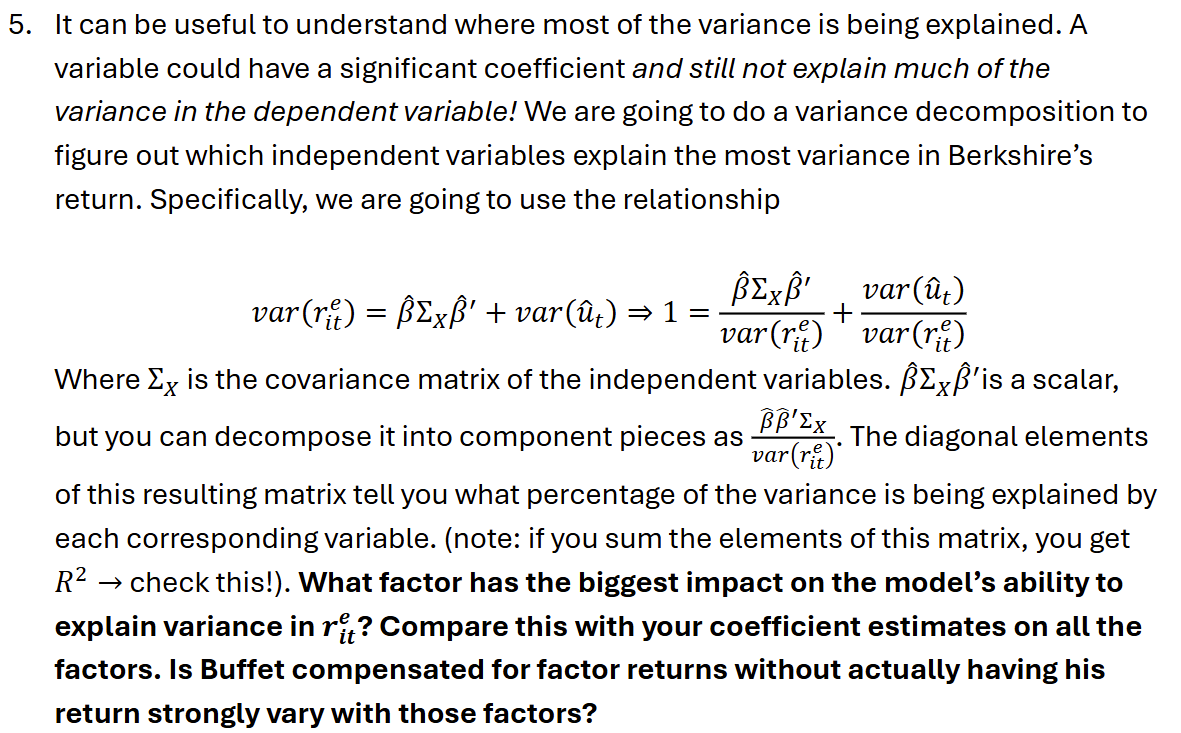

In [156]:
merged_df.columns

Index(['YYYY/MM/DD', 'Returns', 'YYYYMM', 'Year', 'Month',
       'Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)',
       'HML (BM5--value -BM1--growth)', 'Risk-free rate r_f', 'Excess_Return'],
      dtype='object')

In [157]:
# Covariance matrix of factors
factors = merged_df[['Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)', 'HML (BM5--value -BM1--growth)']]
cov_matrix = factors.cov().values

# Extract betas (exclude intercept)
betas = coeffs3[1:]

# Total variance explained
total_var_explained = betas.T @ cov_matrix @ betas

print(f"\nTotal Variance Explained by Factors: {total_var_explained:.6f}")

# Decompose variance
M = cov_matrix @ betas
contributions = betas * M
pct_contribution = (contributions / total_var_explained) * 100

# Results table
decomp_df = pd.DataFrame({
    'Beta': betas,
    'Var Contribution': contributions,
    '% of Variance': pct_contribution
}, index=factors.columns)

print("\n" + decomp_df.to_string())

biggest_factor = decomp_df['% of Variance'].idxmax()
print(f"\nThe '{biggest_factor}' factor has the biggest impact ({decomp_df.loc[biggest_factor, '% of Variance']:.2f}%)")

print("Variance Decomposition Results:")
print(f"  Mkt-RF: {decomp_df.loc['Market Excess (Mkt Return - r_f)', '% of Variance']:.2f}% - Market factor")
print(f"  SMB:    {decomp_df.loc['SMB (ME1-ME5)', '% of Variance']:.2f}% - Size factor")
print(f"  HML:    {decomp_df.loc['HML (BM5--value -BM1--growth)', '% of Variance']:.2f}% - Value factor")

print("\nCritical Observation:")
print(f"  HML Beta = {betas[2]:.4f} (second largest coefficient, highly significant)")
print(f"  HML Variance Contribution = {decomp_df.loc['HML (BM5--value -BM1--growth)', '% of Variance']:.2f}% (relatively small)")


Total Variance Explained by Factors: 0.001197

                                      Beta  Var Contribution  % of Variance
Market Excess (Mkt Return - r_f)  0.825774          0.001095      91.429548
SMB (ME1-ME5)                    -0.298447          0.000029       2.432564
HML (BM5--value -BM1--growth)     0.464207          0.000073       6.137888

The 'Market Excess (Mkt Return - r_f)' factor has the biggest impact (91.43%)
Variance Decomposition Results:
  Mkt-RF: 91.43% - Market factor
  SMB:    2.43% - Size factor
  HML:    6.14% - Value factor

Critical Observation:
  HML Beta = 0.4642 (second largest coefficient, highly significant)
  HML Variance Contribution = 6.14% (relatively small)


### Which factor matters most?

Variance split:

* Mkt-RF: 91.43%
* SMB: 2.43%
* HML: 6.14%

Reading: Market dominates. Over 91% of the systematic variance in Berkshire’s returns comes from broad market moves. That aligns with equities generally being driven by market risk.

### Coefficients vs. variance contribution

Observation:

* HML beta ≈ 0.4642 and statistically strong
* HML variance share ≈ 6.14% and comparatively small

Why both can be true:

1. HML’s own volatility is lower than the market’s.
2. HML is less correlated with Berkshire’s month-to-month swings.
3. The market factor carries higher variance and tighter co-movement with returns.

Lesson: A factor’s variance share depends on beta size, the factor’s volatility, and its correlation with the asset’s returns. Significance does not imply it explains a large portion of variance.

### Is Berkshire getting paid without bearing factor risk?

* HML beta is significant, and HML explains about 6% of variance.
* That means Berkshire does bear some value factor volatility.
* The variance share is modest relative to the coefficient size, which hints at some efficiency in how that value tilt is taken.

SMB’s small contribution (≈2.4%) fits a large-cap profile.

Bottom line: Berkshire has material market exposure and a measured value tilt. There is little evidence of “free” factor premia without risk, but the pattern suggests skillful use of factor exposures alongside alpha.

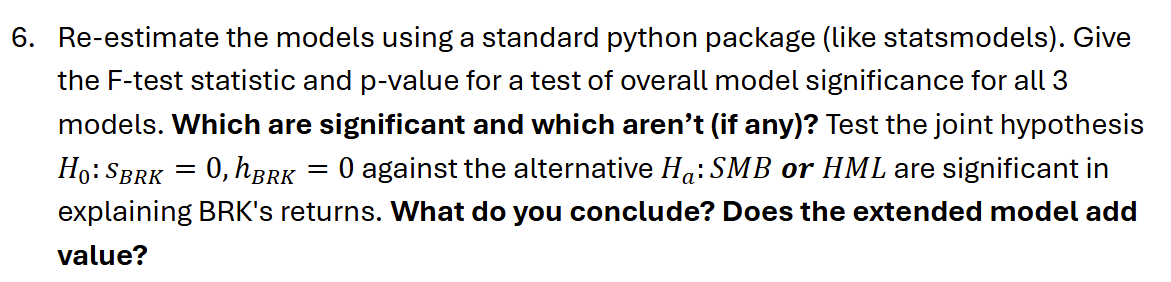

In [158]:
merged_df.columns

Index(['YYYY/MM/DD', 'Returns', 'YYYYMM', 'Year', 'Month',
       'Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)',
       'HML (BM5--value -BM1--growth)', 'Risk-free rate r_f', 'Excess_Return'],
      dtype='object')

In [159]:
# Re-estimate using statsmodels
X1_const = sm.add_constant(merged_df[['Market Excess (Mkt Return - r_f)']])
X2_const = sm.add_constant(merged_df[['Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)']])
X3_const = sm.add_constant(merged_df[['Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)', 'HML (BM5--value -BM1--growth)']])

model1_sm = sm.OLS(y, X1_const).fit()
model2_sm = sm.OLS(y, X2_const).fit()
model3_sm = sm.OLS(y, X3_const).fit()

# Overall F-tests
print("\nOverall Model Significance:")
for name, model in [('CAPM', model1_sm), ('2-Factor', model2_sm), ('FF3', model3_sm)]:
    print(f"  {name:10s}: F={model.fvalue:7.2f}, p={model.f_pvalue:.4f}")

# Joint hypothesis tests
print("\nJoint and Individual Hypothesis Tests:")

joint_test = model3_sm.f_test('SMB (ME1-ME5) = 0, HML (BM5--value -BM1--growth) = 0')
print(f"  H0: SMB=0 AND HML=0:  F={joint_test.fvalue:.2f}, p={joint_test.pvalue:.4f}")

hml_test = model3_sm.f_test('HML (BM5--value -BM1--growth) = 0')
print(f"  H0: HML=0:            F={hml_test.fvalue:.2f}, p={hml_test.pvalue:.4f}")

smb_test = model3_sm.f_test('SMB (ME1-ME5) = 0')
print(f"  H0: SMB=0:            F={smb_test.fvalue:.2f}, p={smb_test.pvalue:.4f}")

print(f"\nConclusion: FF3 model {'adds' if joint_test.pvalue < 0.05 else 'does not add'} significant value over CAPM")


print("\n### Overall Model Significance")
print("All three models highly significant (all p < 0.001):")
print(f"  CAPM:     F = {model1_sm.fvalue:.2f}, p = {model1_sm.f_pvalue:.4f}")
print(f"  2-Factor: F = {model2_sm.fvalue:.2f}, p = {model2_sm.f_pvalue:.4f}")
print(f"  FF3:      F = {model3_sm.fvalue:.2f}, p = {model3_sm.f_pvalue:.4f}")


print("\nJoint and Individual Hypothesis Tests")
print(f"\nH₀: SMB = 0 AND HML = 0")
print(f"  F = {joint_test.fvalue:.2f}, p < 0.001 → REJECT")

print("\nIndividual Tests:")
print(f"  H₀: HML = 0: F = {hml_test.fvalue:.2f}, p < 0.001 → REJECT")
print(f"  H₀: SMB = 0: F = {smb_test.fvalue:.2f}, p = 0.001 → REJECT")


Overall Model Significance:
  CAPM      : F= 134.02, p=0.0000
  2-Factor  : F=  78.58, p=0.0000
  FF3       : F=  63.10, p=0.0000

Joint and Individual Hypothesis Tests:
  H0: SMB=0 AND HML=0:  F=22.15, p=0.0000
  H0: HML=0:            F=24.86, p=0.0000
  H0: SMB=0:            F=11.19, p=0.0009

Conclusion: FF3 model adds significant value over CAPM

### Overall Model Significance
All three models highly significant (all p < 0.001):
  CAPM:     F = 134.02, p = 0.0000
  2-Factor: F = 78.58, p = 0.0000
  FF3:      F = 63.10, p = 0.0000

Joint and Individual Hypothesis Tests

H₀: SMB = 0 AND HML = 0
  F = 22.15, p < 0.001 → REJECT

Individual Tests:
  H₀: HML = 0: F = 24.86, p < 0.001 → REJECT
  H₀: SMB = 0: F = 11.19, p = 0.001 → REJECT


### Bottom line

FF3 beats CAPM for Berkshire. It explains more of the returns and avoids overstating alpha.

### Overall model significance

All specs are highly significant (p < 0.001):

* CAPM: F = 134.02
* 2-Factor: F = 78.58
* FF3: F = 63.10

Reading: Factors as a set matter. The F-stat drops as parameters rise while R² inches up. That is expected and not a red flag.

### Joint vs. individual tests

* H₀: SMB = 0 and HML = 0 → F = 22.15, p < 0.001. Reject.
* H₀: HML = 0 → F = 24.86, p < 0.001. Reject.
* H₀: SMB = 0 → F = 11.19, p = 0.001. Reject.

Both factors add information, and together they add even more.

### Does FF3 add value?

Yes.

1. Joint test strongly significant.
2. Each factor individually significant.
3. R² rises from 20.6% (CAPM) to 26.9% (FF3).


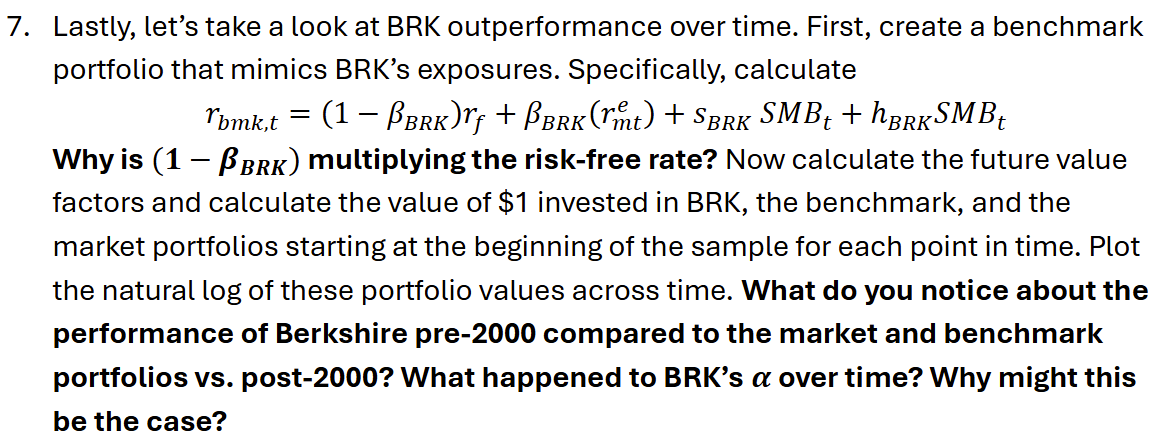

In [160]:
merged_df.columns

Index(['YYYY/MM/DD', 'Returns', 'YYYYMM', 'Year', 'Month',
       'Market Excess (Mkt Return - r_f)', 'SMB (ME1-ME5)',
       'HML (BM5--value -BM1--growth)', 'Risk-free rate r_f', 'Excess_Return'],
      dtype='object')

In [161]:
merged_df

,YYYY/MM/DD,Returns,YYYYMM,Year,Month,Market Excess (Mkt Return - r_f),SMB (ME1-ME5),HML (BM5--value -BM1--growth),Risk-free rate r_f,Excess_Return
0,19761130,0.154412,197611,1976,11,0.0036,0.0232,0.0152,0.0040,0.150412
1,19761231,0.146497,197612,1976,12,0.0565,0.0300,0.0221,0.0040,0.142497
2,19770131,0.000000,197701,1977,1,-0.0405,0.0478,0.0426,0.0036,-0.003600
3,19770228,0.000000,197702,1977,2,-0.0194,0.0108,0.0050,0.0035,-0.003500
4,19770331,0.077778,197703,1977,3,-0.0137,0.0099,0.0102,0.0038,0.073978
...,...,...,...,...,...,...,...,...,...,...
513,20190830,-0.018104,201908,2019,8,-0.0258,-0.0243,-0.0493,0.0016,-0.019704
514,20190930,0.028884,201909,2019,9,0.0143,-0.0099,0.0678,0.0018,0.027084
515,20191031,0.022791,201910,2019,10,0.0206,0.0027,-0.0209,0.0015,0.021291
516,20191129,0.036233,201911,2019,11,0.0387,0.0085,-0.0187,0.0012,0.035033



Beta coefficients being used:
  Mkt-RF: 0.8258
  SMB:    -0.2984
  HML:    0.4642


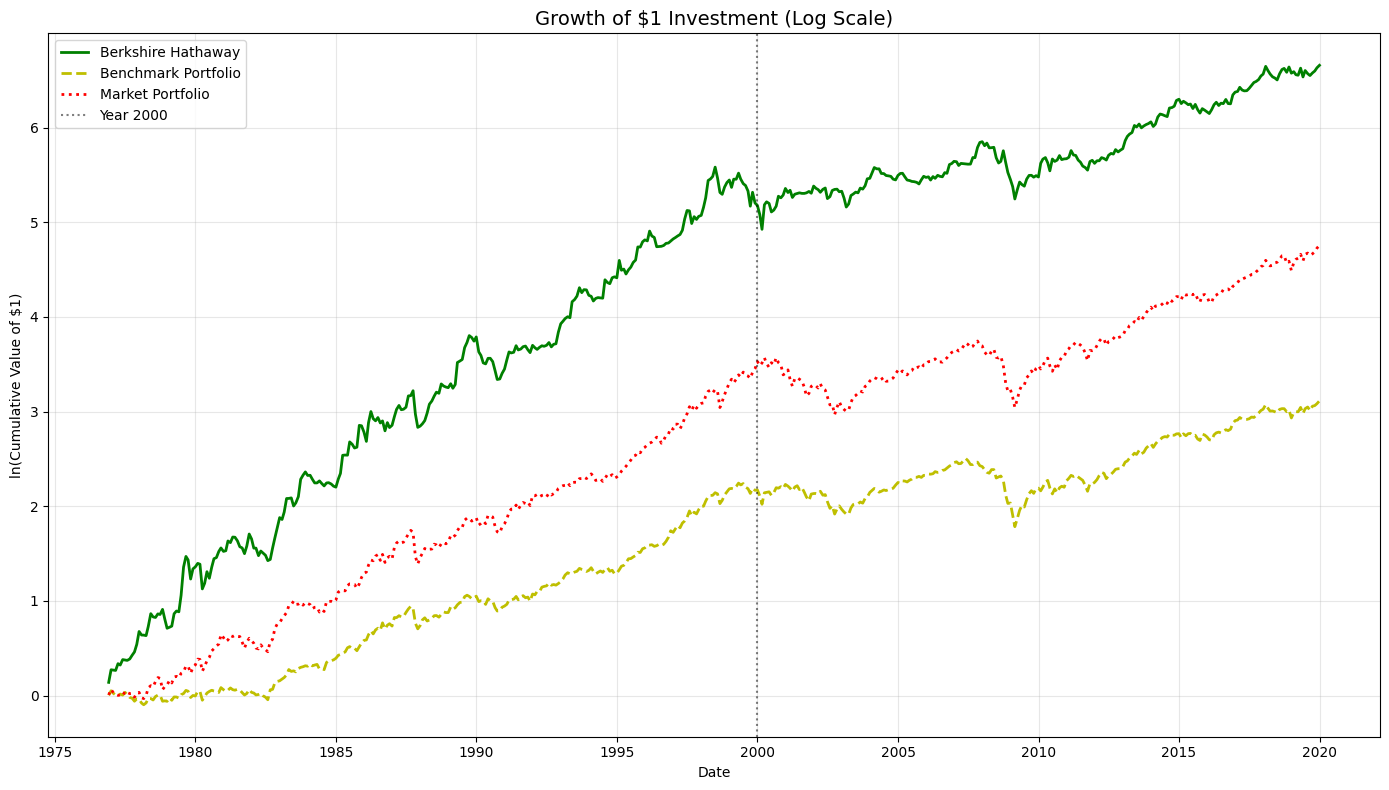


--- Period Analysis Summary ---
              Metric Pre-2000 Post-2000 Full Period
        Berkshire FV  $825.00     $6.05     $778.51
        Benchmark FV    $8.79     $2.56      $22.50
           Market FV   $34.10     $3.41     $116.21
Mean Alpha (monthly)  1.3353%   0.2775%     0.8452%
    Cumulative Alpha  $816.22     $3.49     $756.01


In [168]:
# CRITICAL FIX: Use coefficients from matrix estimation (already in correct units)
beta_mkt = coeffs3[1]  # From our matrix estimation
beta_smb = coeffs3[2]
beta_hml = coeffs3[3]

print(f"\nBeta coefficients being used:")
print(f"  Mkt-RF: {beta_mkt:.4f}")
print(f"  SMB:    {beta_smb:.4f}")
print(f"  HML:    {beta_hml:.4f}")

# Calculate benchmark returns
merged_df['Benchmark_Return'] = ((1 - beta_mkt) * merged_df['Risk-free rate r_f'] + 
                                  beta_mkt * merged_df['Market Excess (Mkt Return - r_f)'] + 
                                  beta_smb * merged_df['SMB (ME1-ME5)'] + 
                                  beta_hml * merged_df['HML (BM5--value -BM1--growth)'])

# Market total return
merged_df['Market_Total_Return'] = merged_df['Risk-free rate r_f'] + merged_df['Market Excess (Mkt Return - r_f)']

# Cumulative values
merged_df['FV_BRK'] = (1 + merged_df['Excess_Return']).cumprod()
merged_df['FV_Benchmark'] = (1 + merged_df['Benchmark_Return']).cumprod()
merged_df['FV_Market'] = (1 + merged_df['Market_Total_Return']).cumprod()

# Alpha
merged_df['alpha_t'] = merged_df['Excess_Return'] - merged_df['Benchmark_Return']

# Create date column
merged_df['Date_dt'] = pd.to_datetime(merged_df['YYYY/MM/DD'], format='%Y%m%d')

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(merged_df['Date_dt'], np.log(merged_df['FV_BRK']), 
         label='Berkshire Hathaway', color='g', linewidth=2)
plt.plot(merged_df['Date_dt'], np.log(merged_df['FV_Benchmark']), 
         label='Benchmark Portfolio', color='y', linestyle='--', linewidth=2)
plt.plot(merged_df['Date_dt'], np.log(merged_df['FV_Market']), 
         label='Market Portfolio', color='r', linestyle=':', linewidth=2)
plt.axvline(pd.Timestamp('2000-01-01'), color='black', linestyle=':', alpha=0.5, label='Year 2000')
plt.title('Growth of $1 Investment (Log Scale)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('ln(Cumulative Value of $1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Period analysis
pre_2000_df = merged_df[merged_df['Date_dt'] < '2000-01-01'].copy()
post_2000_df = merged_df[merged_df['Date_dt'] >= '2000-01-01'].copy()

# Recalculate cumulative values within each period
pre_2000_df['FV_BRK'] = (1 + pre_2000_df['Returns']).cumprod()
pre_2000_df['FV_Benchmark'] = (1 + pre_2000_df['Benchmark_Return']).cumprod()
pre_2000_df['FV_Market'] = (1 + pre_2000_df['Market_Total_Return']).cumprod()

post_2000_df['FV_BRK'] = (1 + post_2000_df['Returns']).cumprod()
post_2000_df['FV_Benchmark'] = (1 + post_2000_df['Benchmark_Return']).cumprod()
post_2000_df['FV_Market'] = (1 + post_2000_df['Market_Total_Return']).cumprod()

# Summary statistics
summary_data = {
    'Metric': ['Berkshire FV', 'Benchmark FV', 'Market FV', 'Mean Alpha (monthly)', 'Cumulative Alpha'],
    'Pre-2000': [
        f"${pre_2000_df['FV_BRK'].iloc[-1]:.2f}",
        f"${pre_2000_df['FV_Benchmark'].iloc[-1]:.2f}",
        f"${pre_2000_df['FV_Market'].iloc[-1]:.2f}",
        f"{pre_2000_df['alpha_t'].mean():.4%}",
        f"${pre_2000_df['FV_BRK'].iloc[-1] - pre_2000_df['FV_Benchmark'].iloc[-1]:.2f}"
    ],
    'Post-2000': [
        f"${post_2000_df['FV_BRK'].iloc[-1]:.2f}",
        f"${post_2000_df['FV_Benchmark'].iloc[-1]:.2f}",
        f"${post_2000_df['FV_Market'].iloc[-1]:.2f}",
        f"{post_2000_df['alpha_t'].mean():.4%}",
        f"${post_2000_df['FV_BRK'].iloc[-1] - post_2000_df['FV_Benchmark'].iloc[-1]:.2f}"
    ],
    'Full Period': [
        f"${merged_df['FV_BRK'].iloc[-1]:.2f}",
        f"${merged_df['FV_Benchmark'].iloc[-1]:.2f}",
        f"${merged_df['FV_Market'].iloc[-1]:.2f}",
        f"{merged_df['alpha_t'].mean():.4%}",
        f"${merged_df['FV_BRK'].iloc[-1] - merged_df['FV_Benchmark'].iloc[-1]:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n--- Period Analysis Summary ---")
print(summary_df.to_string(index=False))

### Period takeaways

* **Pre-2000:** Berkshire crushed both the benchmark and the market, driving the bulk of cumulative alpha and FV growth.
* **Post-2000:** Results cooled and tracked much closer to benchmarks. Alpha persisted but at a much lower run rate.

### Alpha trajectory

* Mean monthly alpha fell from ~1.34% pre-2000 to ~0.28% post-2000.
* The full-period average of ~0.85% reflects exceptional early compounding offset by a subdued modern era.

### Why the shift?

1. Scale effects: A larger capital base makes high-impact ideas harder to source and size.
2. Tighter markets: Valuation gaps narrowed as information and analytics improved.
3. Crowded trade: More capital adopted value frameworks, eroding excess returns.
